In [1]:
!pip install --upgrade "git+https://github.com/nisarahamedk/l5kit.git#egg=l5kit&subdirectory=l5kit" --quiet

Loading l5kit fork

In [2]:
import sys
from pathlib import Path

l5kit_pkg = str(Path("../../l5kit/l5kit").resolve())
l5kit_pkg

sys.path.insert(0, l5kit_pkg) # override the installed package
sys.path

['/home/nisarkavungal_gmx_com/l5kit/l5kit',
 '/home/nisarkavungal_gmx_com/lyft/notebooks',
 '/home/nisarkavungal_gmx_com',
 '/home/nisarkavungal_gmx_com/miniconda3/envs/lyft/lib/python38.zip',
 '/home/nisarkavungal_gmx_com/miniconda3/envs/lyft/lib/python3.8',
 '/home/nisarkavungal_gmx_com/miniconda3/envs/lyft/lib/python3.8/lib-dynload',
 '',
 '/home/nisarkavungal_gmx_com/miniconda3/envs/lyft/lib/python3.8/site-packages',
 '/home/nisarkavungal_gmx_com/miniconda3/envs/lyft/lib/python3.8/site-packages/IPython/extensions',
 '/home/nisarkavungal_gmx_com/.ipython']

### Understanding the l5kit datasets

In [3]:
import os

from l5kit.configs import load_config_data # handle yaml config for data load, model params, etc.
from l5kit.data import LocalDataManager # takes care of the data paths etc.
from l5kit.data import ChunkedDataset # low level Zarr dataset interface.

Importing fork


Environment variable that l5kit uses to set the root path of dataset.

In [4]:
os.environ["L5KIT_DATA_FOLDER"] = "/home/nisarkavungal_gmx_com/lyft-data"

a general config dict is user throughout the l5kit library

In [5]:
train_conf = {
'format_version': 4,
'model_params':{    # this params determines model arch and dataset input/output shapes and sizes.
    'model_architecture': 'resnet50',
    'history_num_frames': 50, # how many frames history you need when you get an item from the dataset
    'history_step_size': 1,
    'history_delta_time': 0.1,
    'future_num_frames': 50, # how many future frames should be, our target comes from this, we need to predict 50 frames to the future
    'future_step_size': 1,
    'future_delta_time': 0.1
    },
'raster_params': {
    'raster_size': [224, 224], # image size of the frames.
    'pixel_size': [0.5, 0.5], # each pixel corresponding how many meters on the map
    'ego_center': [0.25, 0.5], # adjust the location of the agent in question in the map, [0.5,0.5] - agent at the center
    'map_type': 'py_satellite', # satellite image or semantic image
    'satellite_map_key': 'aerial_map/aerial_map.png', # the full arial map of the region
    'semantic_map_key': 'semantic_map/semantic_map.pb', # full semantic map of the region
    'dataset_meta_key': 'meta.json',
    'filter_agents_threshold': 0.5 # in a frame the agents are labelled with a probabilities of their classes. here we say to ignore all agents with <0.5 prob
},
'val_data_loader': {'key': 'scenes/sample.zarr',
'batch_size': 12,
'shuffle': False,
  'num_workers': 16}}

In [6]:
# data manager just check if we have the required files in the system
dm = LocalDataManager()
train_zarr_path = dm.require("scenes/train.zarr") # just check the file exist in the path

In [7]:
train_zarr_path

'/home/nisarkavungal_gmx_com/lyft-data/scenes/train.zarr'

### ChunkedDataset

`ChunkedDataset` is the low level l5kit dataset which just wraps the native Zarr dataset object with simple methods to handle the zarr files.

In [8]:
train_chunk = ChunkedDataset(train_zarr_path)

In [9]:
train_chunk = train_chunk.open() # opens the zarr dataset from the disk. can do on the fly read write to the disk on zarr files

In [10]:
print(train_chunk)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


The actual Zarr dataset object accessed through the `root` attribute

In [11]:
train_chunk.root

<zarr.hierarchy.Group '/' read-only>

However the `ChunkedDataset` provides attributes we can use to get access to the several components of the dataset such as    

#### scenes

In [12]:
train_chunk.scenes

<zarr.core.Array '/scenes' (16265,) [('frame_index_interval', '<i8', (2,)), ('host', '<U16'), ('start_time', '<i8'), ('end_time', '<i8')] read-only>

There are 16256 scenes. the field `frame_index_interval` gives us range index to the frames sub array for each scenes.

Can do row-wise indexing, scene 0 details

In [13]:
train_chunk.scenes[0:5]

array([([   0,  248], 'host-a013', 1572643684617362176, 1572643709617362176),
       ([ 248,  497], 'host-a013', 1572643749559148288, 1572643774559148288),
       ([ 497,  746], 'host-a013', 1572643774559148288, 1572643799559148288),
       ([ 746,  995], 'host-a013', 1572643799559148288, 1572643824559148288),
       ([ 995, 1244], 'host-a013', 1572643824559148288, 1572643849559148288)],
      dtype=[('frame_index_interval', '<i8', (2,)), ('host', '<U16'), ('start_time', '<i8'), ('end_time', '<i8')])

Can also access columnwise. frame interval of all the scenes

In [14]:
train_chunk.scenes["frame_index_interval"]

array([[      0,     248],
       [    248,     497],
       [    497,     746],
       ...,
       [4038783, 4039031],
       [4039031, 4039279],
       [4039279, 4039527]])

####  frames within each scenes

In [15]:
train_chunk.frames

<zarr.core.Array '/frames' (4039527,) [('timestamp', '<i8'), ('agent_index_interval', '<i8', (2,)), ('traffic_light_faces_index_interval', '<i8', (2,)), ('ego_translation', '<f8', (3,)), ('ego_rotation', '<f8', (3, 3))] read-only>

In [16]:
train_chunk.frames[0:5]

array([(1572643684801892606, [  0,  38], [0, 0], [  680.61975098, -2183.32763672,   288.5411377 ], [[ 5.46733141e-01, -8.37294340e-01,  4.59085545e-03], [ 8.35287392e-01,  5.45025647e-01, -7.24018440e-02], [ 5.81195243e-02,  4.34191711e-02,  9.97364998e-01]]),
       (1572643684901714926, [ 38,  85], [0, 0], [  681.18560791, -2182.42236328,   288.60812378], [[ 5.47081292e-01, -8.37059736e-01,  5.74750407e-03], [ 8.35097909e-01,  5.45301139e-01, -7.25131184e-02], [ 5.75636923e-02,  4.44702990e-02,  9.97350872e-01]]),
       (1572643685001499246, [ 85, 142], [0, 0], [  681.76470947, -2181.52270508,   288.68093872], [[ 5.47960341e-01, -8.36487472e-01,  5.30776521e-03], [ 8.34573150e-01,  5.46253383e-01, -7.13788122e-02], [ 5.68080992e-02,  4.35424782e-02,  9.97435153e-01]]),
       (1572643685101394026, [142, 200], [0, 0], [  682.34143066, -2180.62426758,   288.75592041], [[ 5.49122512e-01, -8.35734189e-01,  3.57811200e-03], [ 8.33713591e-01,  5.47486722e-01, -7.19717517e-02], [ 5.8190286

Using `frame_index_interval` for a scene to get the frames of that particular scene

In [17]:
scene_idx = 0
frame_slice = slice(*train_chunk.scenes["frame_index_interval"][scene_idx])
print(frame_slice)
len(train_chunk.frames[frame_slice])

slice(0, 248, None)


248

#### agents within each frame

In [18]:
print(f"Agents: {train_chunk.agents}")

Agents: <zarr.core.Array '/agents' (320124624,) [('centroid', '<f8', (2,)), ('extent', '<f4', (3,)), ('yaw', '<f4'), ('velocity', '<f4', (2,)), ('track_id', '<u8'), ('label_probabilities', '<f4', (17,))] read-only>


In [19]:
train_chunk.agents[0:50]["track_id"]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
      dtype=uint64)

In summary, the dataset is arranged in a way that,  

- There are a bunch of scenes in the scene sub array
- Each scene has a set of frames (248 frames), which is in the frames subarray
- Each frame has a certain number of agents in it. which is given the agent_index_interval
- and for each agent in a frame we have its position, track_id, type of agent etc.

### Looking at a single scene - Scene 0

In [20]:
train_chunk.scenes[0]

([  0, 248], 'host-a013', 1572643684617362176, 1572643709617362176)

We know from above that, 

- The scene has 249 frames.
- and we can index to the frame sub array [0:248] to get the frames

#### frame 0

Lets look at the starting frame of the scene, that is frame 0, we can get that by indexing to the frames array with index 0

In [21]:
train_chunk.frames[0]

(1572643684801892606, [ 0, 38], [0, 0], [  680.61975098, -2183.32763672,   288.5411377 ], [[ 0.54673314, -0.83729434,  0.00459086], [ 0.83528739,  0.54502565, -0.07240184], [ 0.05811952,  0.04341917,  0.997365  ]])

Now we know that (looking at the second field), that this frame has 39 agents in it. [0:38], inorder to gets the positions of those agents in the frame. we need to look in the agents array.

Lets look at one of the agent's information

In [22]:
train_chunk.agents[0] # the first agent of the first frame of the first scene

([  665.03424072, -2207.51220703], [4.3913283, 1.8138304, 1.5909758], 1.0166751, [0., 0.], 1, [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Here we go, we have the centroid, extant(length-like), yaw (rotation) etc. all the information needed to place that agent on to the frame

Now lets look at the next frame - frame 1

#### frame 1

In [23]:
train_chunk.frames[1]

(1572643684901714926, [38, 85], [0, 0], [  681.18560791, -2182.42236328,   288.60812378], [[ 0.54708129, -0.83705974,  0.0057475 ], [ 0.83509791,  0.54530114, -0.07251312], [ 0.05756369,  0.0444703 ,  0.99735087]])

In [24]:
85-38

47

This frame has in total 47 agents on it. So more agents are visible in this frame than in frame 0

To look at one of the agent, we just simply index to the agents array

In [25]:
train_chunk.agents[39]

([  717.61236572, -2174.77197266], [2.8158894 , 0.19811006, 1.030693  ], -0.7868708, [0., 0.], 2, [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Now how do we track the same agent position from one frame to another?

Using track_id

We know that agents [0:38] are in frame 0

In [26]:
train_chunk.agents[0:38]["track_id"]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38], dtype=uint64)

and agents [38:85] in frame 1

In [27]:
train_chunk.agents[38:85]["track_id"]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], dtype=uint64)

Using `track_id` we can track the position of an agent from one frame to another in a scene.  

Here agents[0] is the position of agent id 1 in frame 0. and  
agents[38] is the position of the agent id 1 in frame 1.

#### Rasterizer to visualize the scenes

Rasterization is basically building an image of a frame.  

For a particular frame, we know the agents in it. their positions, yaw, every detail.  

The rasterizer just put those agents in an image of choice.  

- Either in a Semantic Map, or

- in a Satellite Map.
   - The complete satellite map is pre built. and the rasterizer just snips that map image and put agents on it and return.

In [28]:
from l5kit.rasterization import build_rasterizer

Rasterizer takes in the cfg dict and the local data manager instance (which just holds the path to zarr)

In [29]:
## Two types of rasterizer -> 

# 1. Semantic (simple birds eye view)
train_conf["raster_params"]["map_type"] = "py_semantic"
raster_sem = build_rasterizer(train_conf, dm)

# 2. Satellite (more detailed)
train_conf["raster_params"]["map_type"] = "py_satellite"
raster_sat = build_rasterizer(train_conf, dm)

In [30]:
raster_sat

In [31]:
raster_sat.raster_size

array([224, 224])

### EgoDataset and AgentDataset

Higher level Pytorch dataset that can be used for training

In [32]:
from l5kit.dataset import AgentDataset

In [33]:
agent_dataset = AgentDataset(train_conf, train_chunk, raster_sat)
print(agent_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [34]:
len(agent_dataset)

22496709

This is less than the total agents because we chose to ignore agents with < 0.5 probabilties in their labels.   

There are other criteria as well in l5kit to filter the agents.

In [35]:
list(agent_dataset[0].keys())

['image',
 'target_positions',
 'target_yaws',
 'target_availabilities',
 'history_positions',
 'history_yaws',
 'history_availabilities',
 'world_to_image',
 'raster_from_world',
 'raster_from_agent',
 'agent_from_world',
 'world_from_agent',
 'track_id',
 'timestamp',
 'centroid',
 'yaw',
 'extent']

We have

#### Image

stacked image if we have selected > 1 history_num_frames

In [36]:
agent_dataset[0]["image"].shape

(105, 224, 224)

> #### Image shape explained   
    - 512x512 - the raster size - size of the image returned
    - 105 - In blow order,
        - 51 gray scale 1D image of agent boxes other than the current agent (agent we are predicting the future of) - one for each frame in the history
        - 51 gray scale 1D image of agent box of the current agent - one for each history frame.
        - 3 the RGB 3D image of the satellite crop image.

#### Target positions

labels we need to predict, x and y co-ordinates of the future positions of the agent.

In [37]:

agent_dataset[0]["target_positions"].shape

(50, 2)

#### Target availabilities

Although we asked for the future 50 positions of this agent. the agent might not have future 50 positions or it can have more than 50 positions.  

The `target_availabilities` mask gives a sense to how many valid target positions are there for this agent.  


Is the target label valid for the respective positions. Need to take this account in the loss function.

In [38]:
agent_dataset[0]["target_availabilities"]

array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

#### History position

past positions of this agent. Note that in the config we mentioned we wanted 50 history frames. but here we have got only 11. others are 0. This is because this agent is selected at <50 frames in the scene. 11th frame to be exact. therefore, there will be only 11 possible history frames.   

Which means it is not guaranteed to have the # of history frames specified in the config. This is taken care in the agent filtering mechanics. and the mask is available in `history_availabilities`.

In [39]:

agent_dataset[0]["history_positions"]

array([[  0.        ,   0.        ],
       [ -0.8327797 ,  -0.02034835],
       [ -1.6913595 ,  -0.05923422],
       [ -2.5541222 ,  -0.08904176],
       [ -3.422796  ,  -0.10623392],
       [ -4.284609  ,  -0.15802377],
       [ -6.034649  ,  -0.33230996],
       [ -7.649112  ,  -0.36506152],
       [ -8.80825   ,  -0.39701042],
       [ -9.3324175 ,  -0.43215683],
       [ -9.416542  ,  -0.4382079 ],
       [-12.629728  ,  -0.19397324],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
 

In [40]:
agent_dataset[0]["history_availabilities"]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

### Convert the image array to RGB so that we can visualize it  

As seen above, the `image` attribute returned in the agent dataset, is a stack of all agent + surrounding agents gray scale box images.  

In order to put all those together into a nice visualizable RGB image. need to call `to_rgb` of rasterizer.

In [44]:
# ### if DEBUG, need to attach the vscode DAP client to this and set breakpoints in the code somewhere.
import debugpy
debugpy.listen(5678)

('127.0.0.1', 5678)

In [45]:
def to_image():
    # image within that data object
    frame_data = agent_dataset[1]
    print(frame_data["image"].shape)
    return agent_dataset.rasterizer.to_rgb(frame_data["image"].transpose(1, 2, 0))

frame_img = to_image()

(105, 224, 224)


#### sat_box_rasterizer to_rgb() working

- hand the `image` array to the `BoxRasterizer`'s `to_rgb`, which
    - first go through the first half of the `image` array.
        - which contains the surrounding agents bounding boxes.
        - and put it into a single 1D image with color gradients to indicate the movement of all the agents through the frame historyu
    - then second half of the `image` array, which
        - which contains the agent in question bounding boxes through the history.
        - put into a single 1D image, with color gradients (different color here)
    - combine both these 1D images into a single 1D image and return.
- hande the `image` array to the `SatelliteRasterizer, which
    - which just returns the last 3 dimension of the `image` array.
    - which has the satellite image crop in RGB

- Stitch together these two images to get the final RGB

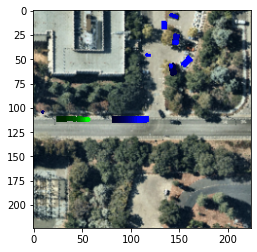

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(frame_img)

The above image captures the complete frame history of the agent till the present.  

This is stitched together from the n dimensional image array in agentdataset. which had
- all historing box gray scale 1D images of the surrounding agents - in this case 51 frames (although 11 frames of actual data available)
- all historing box gray scale 1D image of the agent in question - 51 as above.
- and the satellite map crop image RGB  

From all this, the above image is stitched. So can you see the movement of the agent through history as a gradient.